# Reverse Sigmoid (Post-processing)
---

### API Reference:
- hhttps://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/postprocessor.html#reverse-sigmoid

### Related Paper:
- https://arxiv.org/abs/1806.00054

### Description
- In this demo, we check a reverse sigmoid which is an one of the post-porcess defence. To do this, we select the extraction attacks such as [Copycat CNN](https://arxiv.org/abs/1806.05476) and [KnockoffNets](https://arxiv.org/abs/1812.02766), then apply the reverse sigmoid to them and chekc the results.

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution() # To use the ART
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Flatten, InputLayer, Reshape

from art.estimators.classification import KerasClassifier

### Laod MNIST dataset

In [3]:
import art
from art.utils import load_mnist

(x_train, y_train), (x_test0, y_test0), min_, max_ = load_mnist()
len_steal = 5000
indices = np.random.permutation(len(x_test0))
x_steal = x_test0[indices[:len_steal]]
y_steal = y_test0[indices[:len_steal]]
x_test = x_test0[indices[len_steal:]]
y_test = y_test0[indices[len_steal:]]

## Define the model and train it

In [6]:
im_shape = x_train[0].shape
def get_model(num_classes=10, c1=32, c2=64, d1=128):
    model = Sequential()
    model.add(Conv2D(c1, kernel_size=(3, 3), activation='relu', input_shape=im_shape))
    model.add(Conv2D(c2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer="sgd",
                          metrics=['accuracy'])
    return model

In [7]:
# Train the original model.
num_epochs = 5
model = get_model(num_classes=10, c1=32, c2=64, d1=128)
print("Original model training:")
model.fit(x_train, y_train, batch_size=100, epochs=num_epochs)
print("Original model evaluation:")
print(model.evaluate(x_test, y_test))
classifier_original = KerasClassifier(model, clip_values=(min_, max_), use_logits=False)

Original model training:
Train on 60000 samples


2021-12-21 15:16:50.625466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 15:16:50.626050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 15:16:50.629826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 15:16:50.630434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 15:16:50.630903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/5


2021-12-21 15:16:51.867932: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


60000/60000 [==============================] - 4s 68us/sample - loss: 0.6190 - accuracy: 0.8309
Epoch 2/5
60000/60000 [==============================] - 2s 39us/sample - loss: 0.2482 - accuracy: 0.9255
Epoch 3/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.1853 - accuracy: 0.9434
Epoch 4/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1525 - accuracy: 0.9535
Epoch 5/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.1307 - accuracy: 0.9605
Original model evaluation:


/archive/library/anaconda3/envs/tta/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[0.12971224214732646, 0.9602]


In [8]:
x_test_pred = np.argmax(classifier_original.predict(x_test[:100]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(100-nb_correct_pred))

Original test data (first 100 images):
Correctly classified: 98
Incorrectly classified: 2


### Extraction attacks using CopycatCNN and KnockoffNets

In [9]:
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets

attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

results = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 339us/sample - loss: 2.3203 - accuracy: 0.0760
Epoch 2/5
250/250 [==============================] - 0s 42us/sample - loss: 2.3028 - accuracy: 0.1400
Epoch 3/5
250/250 [==============================] - 0s 41us/sample - loss: 2.2864 - accuracy: 0.2240
Epoch 4/5
250/250 [==============================] - 0s 39us/sample - loss: 2.2707 - accuracy: 0.2560
Epoch 5/5
250/250 [==============================] - 0s 38us/sample - loss: 2.2547 - accuracy: 0.2560
Probabilistic CopycatCNN : 0.18420513
Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 201us/sample - loss: 2.2971 - accuracy: 0.2080
Epoch 2/5
250/250 [==============================] - 0s 46us/sample - loss: 2.2823 - accuracy: 0.2520
Epoch 3/5
250/250 [==============================] - 0s 40us/sample - loss: 2.2689 - accuracy: 0.2920
Epoch 4/5
250/250 [==============================] - 0s 40us/sample - loss: 2.2549 - accuracy: 0.3360


#### Result of model extraction with CopycatCNN and KnockoffNets

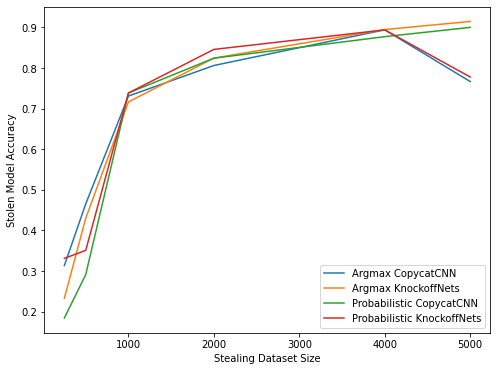

In [10]:
import pandas as pd
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

### Create protected classifier with reverse sigmoid

In [12]:
from art.defences.postprocessor import ReverseSigmoid

postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2)
classifier_protected = KerasClassifier(model, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

# Below is used by `FunctionallyEquivalentExtraction`.
model_flat = Sequential([InputLayer([784]), Reshape([28, 28, 1]), model])
model_flat.compile('sgd', 'categorical_crossentropy', ['accuracy'])
classifier_flat_protected = KerasClassifier(model_flat, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

#### Apply the protected classifier to CopycatCNN and KnockoffNets

In [13]:
# Stealing from the protected classifier.

attack_catalogue = {
                    "Probabilistic CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
#                     "FunctionallyEquivalentExtraction": FunctionallyEquivalentExtraction(classifier=classifier_flat_protected,
#                                               num_neurons=128),  # This one takes too long time for this dataset/model.
                    }

results_protected = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        if name=="FunctionallyEquivalentExtraction":
            classifier_stolen = attack.extract(np.reshape(x_steal, [len(x_steal), -1]), y_steal, thieved_classifier=classifier_stolen)
        else:
            classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results_protected.append((name, len_steal, acc))


/archive/library/anaconda3/envs/tta/lib/python3.7/site-packages/art/defences/postprocessor/reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)


Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 270us/sample - loss: 2.3051 - accuracy: 0.0960
Epoch 2/5
250/250 [==============================] - 0s 46us/sample - loss: 2.3048 - accuracy: 0.0920
Epoch 3/5
250/250 [==============================] - 0s 43us/sample - loss: 2.3045 - accuracy: 0.0920
Epoch 4/5
250/250 [==============================] - 0s 43us/sample - loss: 2.3042 - accuracy: 0.0920
Epoch 5/5
250/250 [==============================] - 0s 41us/sample - loss: 2.3040 - accuracy: 0.0880


/archive/library/anaconda3/envs/tta/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Probabilistic CopycatCNN (vs. Protected) : 0.101538464
Train on 250 samples
Epoch 1/5
250/250 [==============================] - 0s 276us/sample - loss: 2.2958 - accuracy: 0.1400
Epoch 2/5
250/250 [==============================] - 0s 43us/sample - loss: 2.2725 - accuracy: 0.1920
Epoch 3/5
250/250 [==============================] - 0s 43us/sample - loss: 2.2465 - accuracy: 0.2600
Epoch 4/5
250/250 [==============================] - 0s 41us/sample - loss: 2.2221 - accuracy: 0.3440
Epoch 5/5
250/250 [==============================] - 0s 41us/sample - loss: 2.1948 - accuracy: 0.3760
Argmax CopycatCNN (vs. Protected) : 0.38820514
Probabilistic KnockoffNets (vs. Protected) : 0.12030769
Argmax KnockoffNets (vs. Protected) : 0.19876923
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 169us/sample - loss: 2.3039 - accuracy: 0.0740
Epoch 2/5
500/500 [==============================] - 0s 42us/sample - loss: 2.3034 - accuracy: 0.0900
Epoch 3/5
500/500 [================

Contrary to the previous results, the following results show that the accuracy of stolen models are below. This mean reverse sigmoid protected the original model from extraction attacks.

In [18]:
import pandas as pd
df_protected = pd.DataFrame(results_protected, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))


# fig, ax = plt.subplots(figsize=(8,6))
# ax.set_xlabel("Stealing Dataset Size")
# ax.set_ylabel("Stolen Model Accuracy")
# for name, group in df_protected.groupby("Method Name"):
#     group.plot(1, 2, ax=ax, label=name)
# plt.show()

In [19]:
df_combined = pd.concat([df, df_protected])
groupby = df_combined.groupby("Method Name")

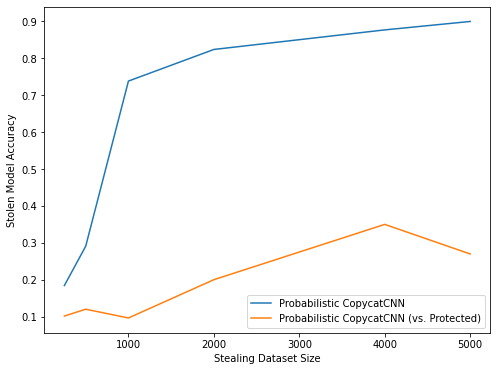

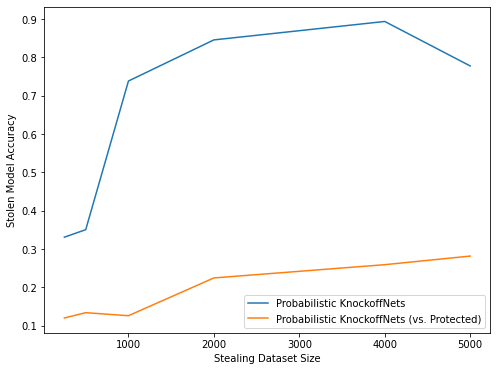

In [20]:
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (vs. Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (vs. Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()